In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch

import models.pd_decoders
import models.generators
import models.pi_models
import models.point_clouds_encoders
import models.data_to_pd_models
import models.image_encoders
import train_models

from torch.nn import MSELoss, CrossEntropyLoss
from persim import PersistenceImager
from gudhi.representations.vector_methods import PersistenceImage as PersistenceImageGudhi
import wandb
import random

from get_datasets import get_loaders_by_name
import utils.metrics
from utils.loss_functions import ChamferLoss, HungarianLoss, SlicedWasserstein

from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR, ReduceLROnPlateau, SequentialLR

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
dataset_name = 'Obayashi-Hiraoka'
batch_size = 64
dataloader_train, dataloader_test, num_classes, n_max = get_loaders_by_name(dataset_name, batch_size)

TypeError: get_loaders_by_name() missing 1 required positional argument: 'data_type'

In [ ]:
for 

In [7]:
in_channels = 1
size_predictor = models.image_encoders.SimpleCNNEncoder(in_channels=1, n_out_enc=1).to(device)

# make encoders brute force maybe
latent_dim = 1024
encoder = models.image_encoders.SimpleCNNEncoder(in_channels=1, n_out_enc=latent_dim).to(device)
generator = models.generators.TopNGenerator(set_channels=in_channels, cosine_channels=32, max_n=n_max + 20, 
                                            latent_dim=latent_dim).to(device)
decoder = models.pd_decoders.TransformerDecoder(n_in=in_channels, latent_dim=latent_dim, fc_dim=1024, 
                                                num_heads=8, num_layers=5, n_out=2,
                                                generator=generator, n_out_lin=256, n_hidden=512, num_layers_lin=3,
                                                dropout = 0.1, use_conv=False).to(device)

model = models.data_to_pd_models.OneShotPd(encoder, decoder, size_predictor=size_predictor, n_max=n_max).to(device)

In [8]:
model.load_state_dict(torch.load('pretrained_models/final_full_model_simplecnn_topn_Obayashi-Hiraoka_run_0.pt'))

<All keys matched successfully>

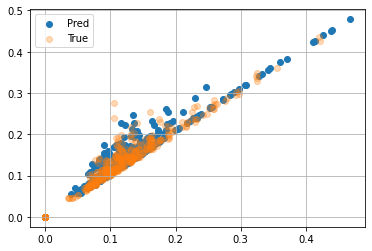

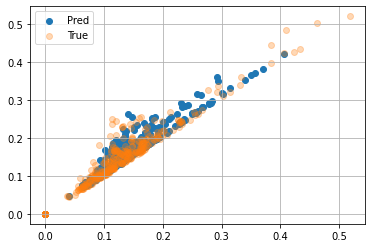

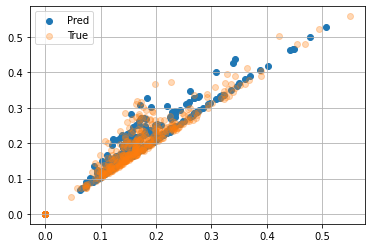

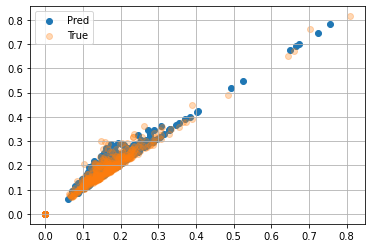

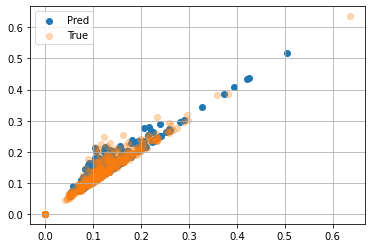

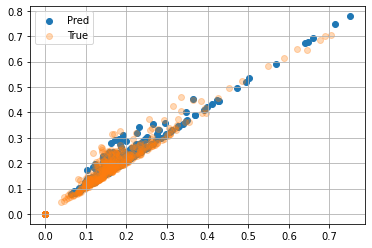

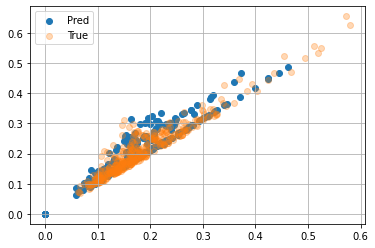

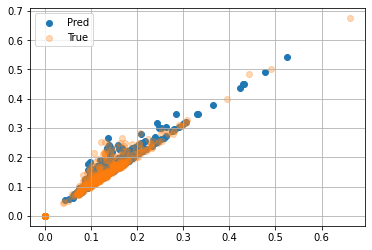

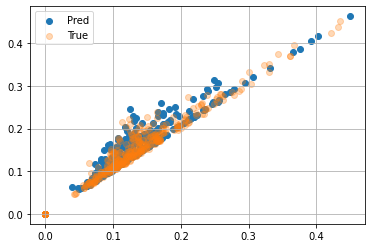

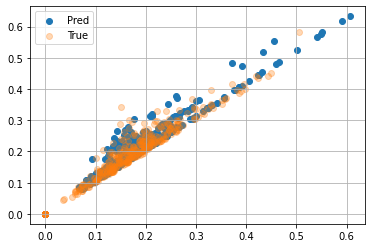

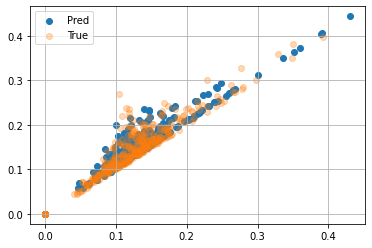

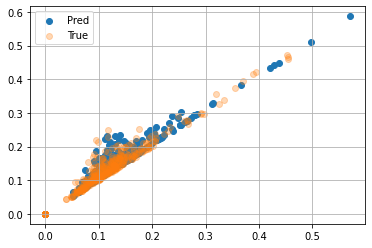

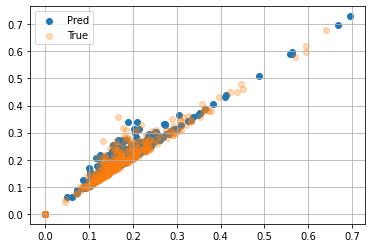

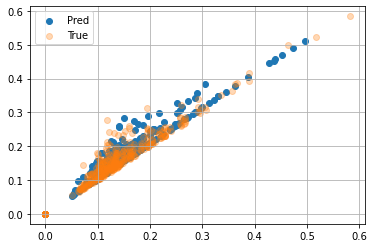

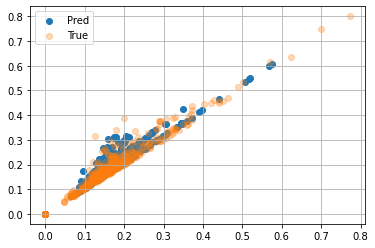

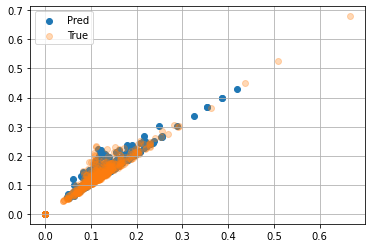

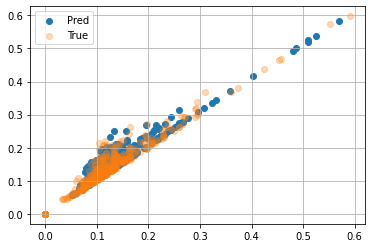

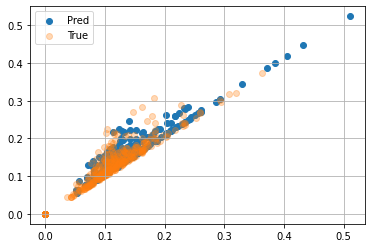

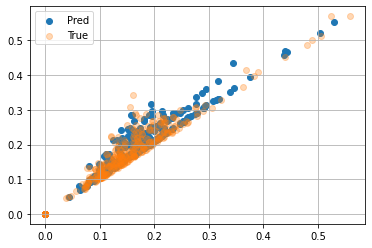

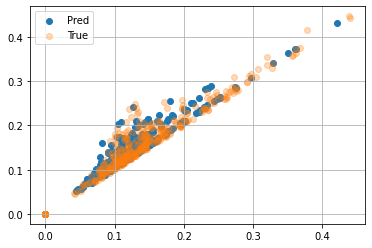

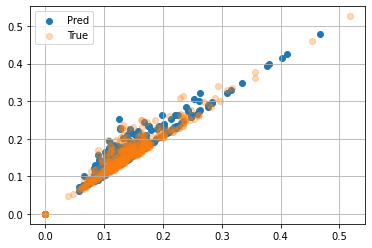

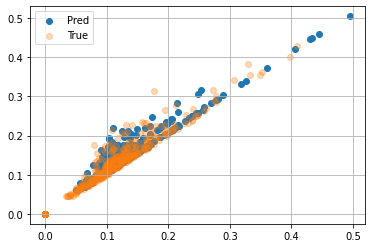

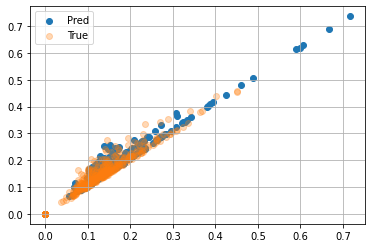

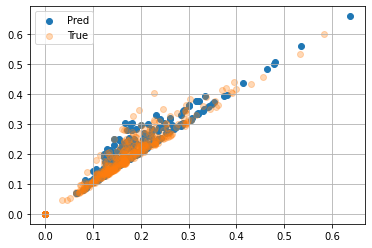

In [9]:
with torch.no_grad():
    for src_pd, mask, labels, src_data, PI in dataloader_test:
        pred_pd = model(src_data.to(device)).cpu().numpy()
        pred_pd[..., 1] += pred_pd[..., 0]
        src_pd[..., 1] += src_pd[..., 0]
        plt.scatter(pred_pd[0, :, 0], pred_pd[0, :, 1], label = 'Pred')
        plt.scatter(src_pd[0, :, 0], src_pd[0, :, 1], label = 'True', alpha = 0.3)
        plt.grid()
        plt.legend()
        plt.show()

In [2]:
pimgr = PersistenceImageGudhi(bandwidth=3e-3, resolution=[50, 50], weight=lambda x: (x[1])**2, 
                                  im_range=[0, 0.12, 0, 0.12])

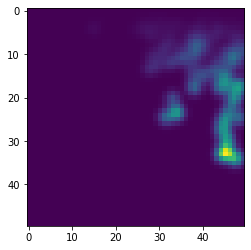

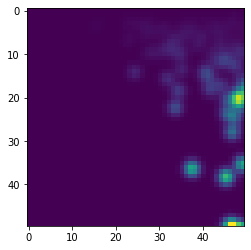

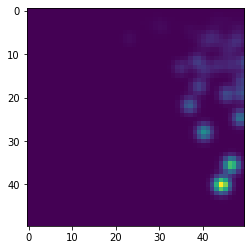

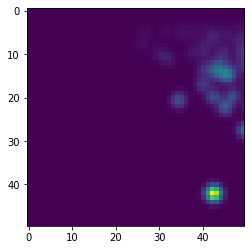

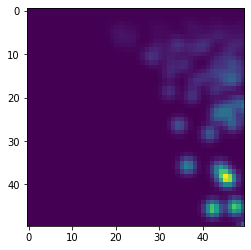

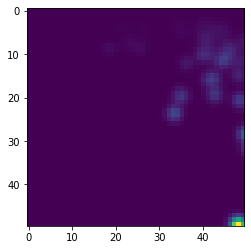

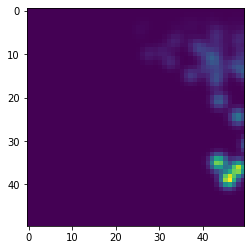

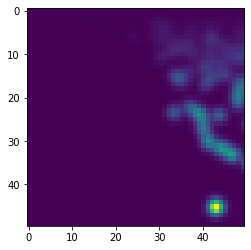

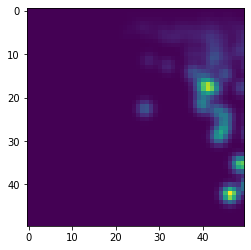

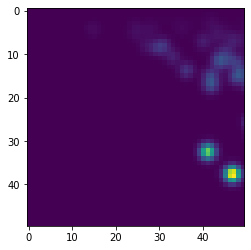

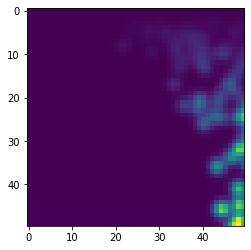

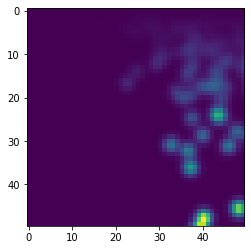

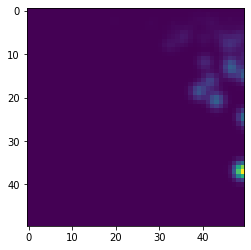

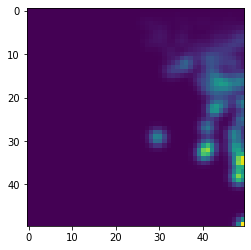

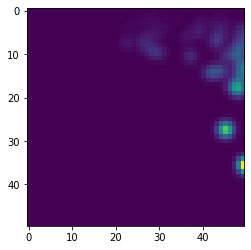

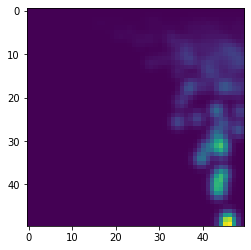

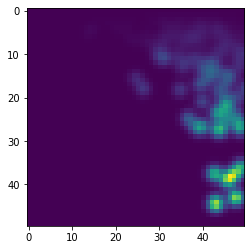

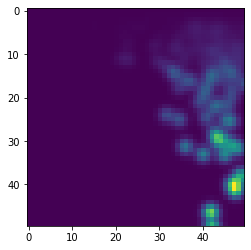

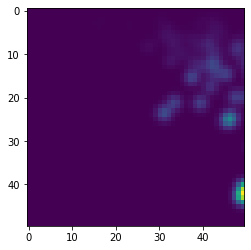

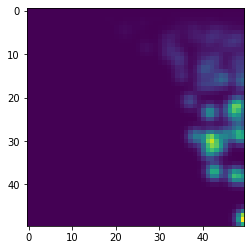

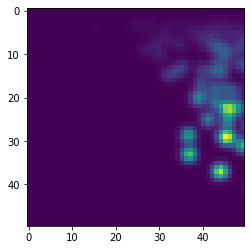

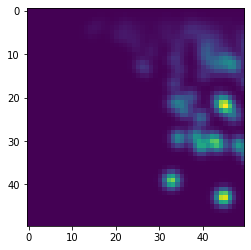

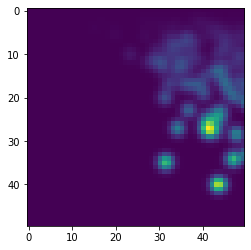

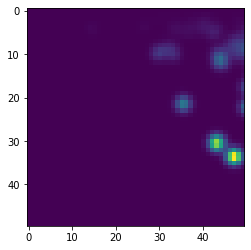

In [11]:
with torch.no_grad():
    for src_pd, mask, labels, src_data, PI in dataloader_test:
        src_pd[..., 1] += src_pd[..., 0]
        pis = pimgr.fit_transform(src_pd)
        plt.imshow(pis[0].reshape(50, 50))
        plt.show()

In [2]:
dataset_name = 'Orbit5k'
batch_size = 64
dataloader_train, dataloader_test, num_classes, n_max = get_loaders_by_name(dataset_name, batch_size)

In [3]:
pimgr = PersistenceImageGudhi(bandwidth=3e-3, resolution=[50, 50], weight=lambda x: (x[1])**2, 
                                  im_range=[0, 0.12, 0, 0.12])

In [16]:
in_channels = 2

topology_net = models.pi_models.TopologyNet(in_channels=in_channels).to(device)
ripsnet = models.pi_models.RipsNet(in_channels=in_channels).to(device)

In [22]:
topology_net.load_state_dict(torch.load('pretrained_models/topologynet_Orbit5k_run_0.pt'))
ripsnet.load_state_dict(torch.load('pretrained_models/ripsnet_Orbit5k_run_0.pt'))

<All keys matched successfully>

tensor(0., device='cuda:0') tensor(0.9221, device='cuda:0') tensor(2.9833, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.8630, device='cuda:0') tensor(2.7007, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.8560, device='cuda:0') tensor(2.7368, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.8993, device='cuda:0') tensor(2.6556, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.8085, device='cuda:0') tensor(2.6385, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.9036, device='cuda:0') tensor(2.7937, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.8646, device='cuda:0') tensor(2.7420, device='cuda:0')
tensor(0., device='cuda:0') tensor(1.0210, device='cuda:0') tensor(2.8864, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.8853, device='cuda:0') tensor(2.7767, device='cuda:0')
tensor(0., device='cuda:0') tensor(1.0770, device='cuda:0') tensor(2.8546, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.8019, device='cuda:0') tensor(2.7180, devic

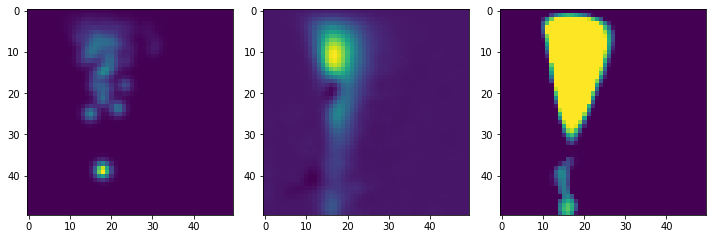

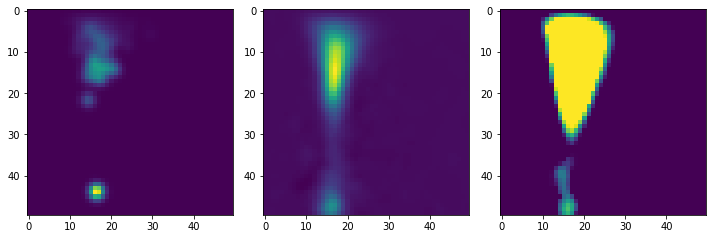

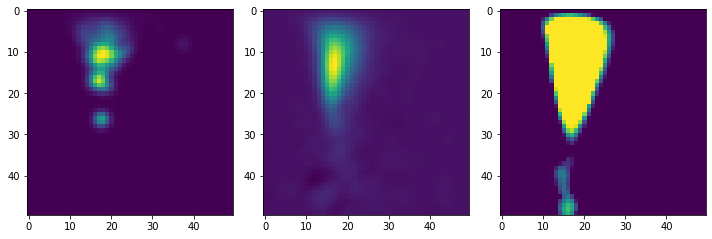

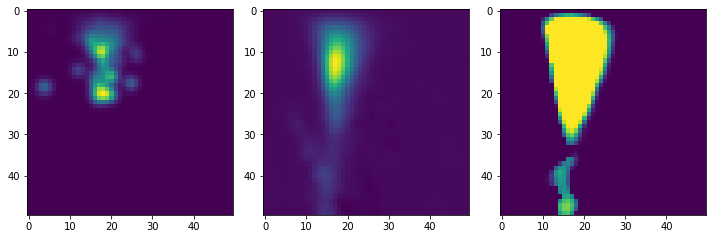

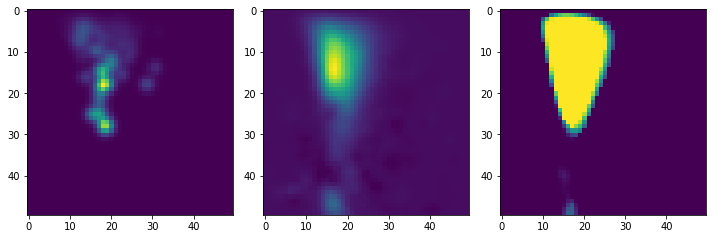

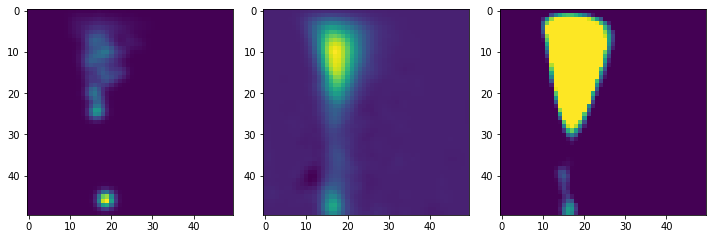

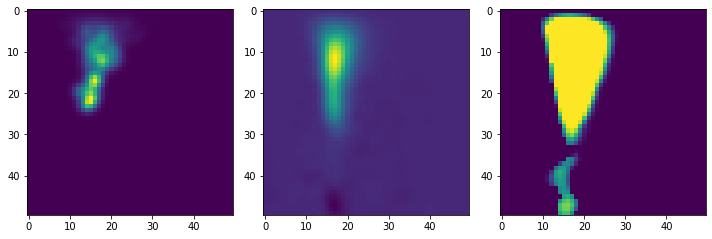

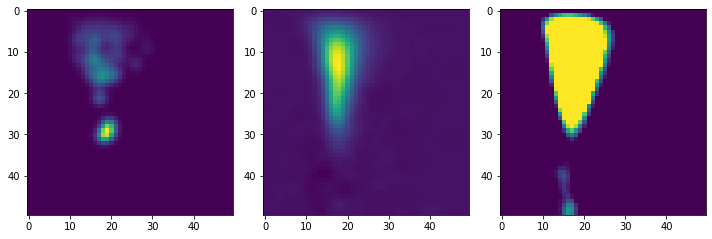

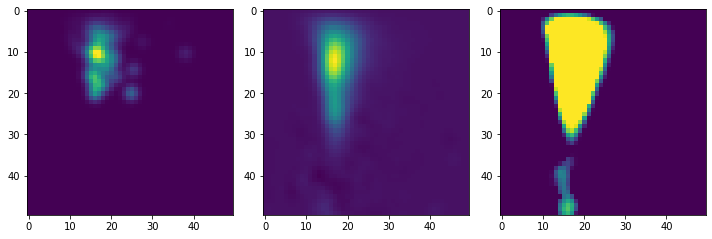

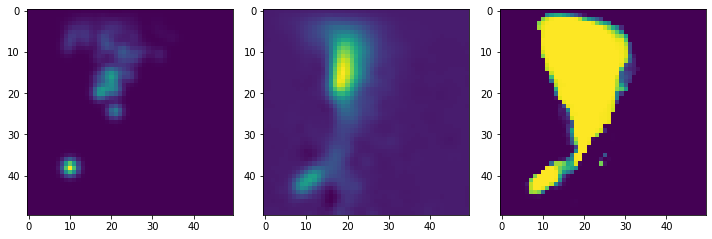

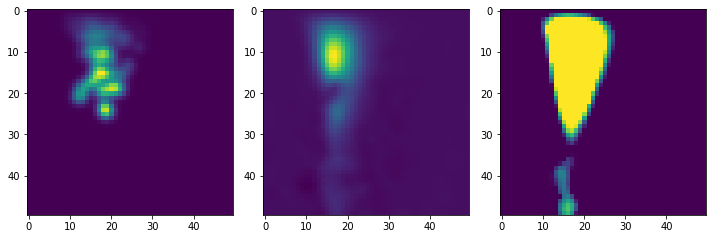

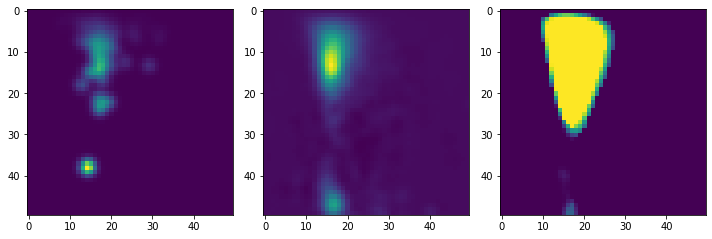

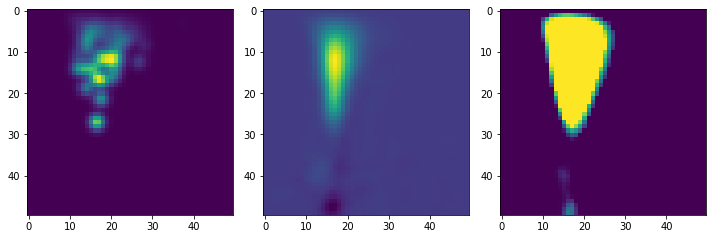

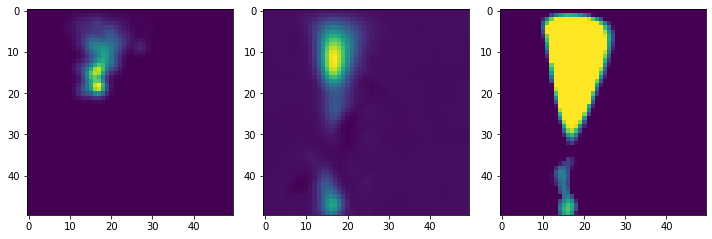

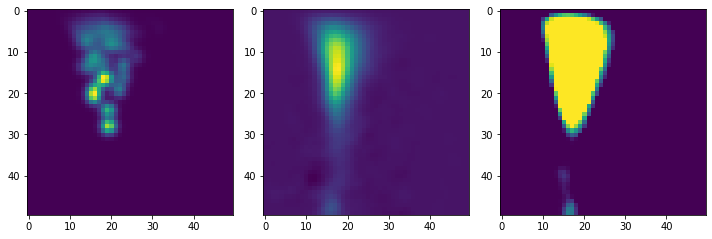

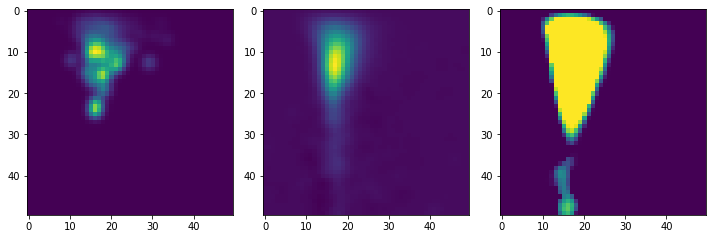

In [32]:
kek = MSELoss()
with torch.no_grad():
    for _, _, _, data, PI in dataloader_test:
        pred = topology_net(data.to(device)).reshape(-1, 50, 50)
        PI = PI.reshape(-1, 50, 50).to(device)
        pred1 = ripsnet(data.to(device)).reshape(-1, 50, 50)
        
        print(kek(PI, PI) / PI.shape[0], kek(PI, pred) / PI.shape[0],
              kek(PI, pred1) / PI.shape[0])
        
        fig, axs = plt.subplots(1, 3, figsize=(10,5))
        axs[0].imshow(PI[0].reshape(50, 50).cpu())
        axs[1].imshow(pred[0].cpu())
        axs[2].imshow(pred1[0].cpu())
        plt.tight_layout()

In [5]:
in_channels = 2

ripsnet = models.pi_models.RipsNet(in_channels=in_channels).to(device)
name = 'ripsnet'
ripsnet = train_models.train_pi_model(ripsnet, dataloader_train, dataloader_test, 
                                                  crit=CrossEntropy(), name=name, lr=1e-4)

0 train loss ripsnet 2.912191390991211 test loss ripsnet 2.9147403240203857
1 train loss ripsnet 2.760838508605957 test loss ripsnet 2.6117379665374756
2 train loss ripsnet 2.228381872177124 test loss ripsnet 1.847269892692566
3 train loss ripsnet 1.4566824436187744 test loss ripsnet 1.2231407165527344
4 train loss ripsnet 1.0982447862625122 test loss ripsnet 1.0843141078948975
5 train loss ripsnet 1.032440423965454 test loss ripsnet 1.0634942054748535
6 train loss ripsnet 1.020241379737854 test loss ripsnet 1.0600950717926025
7 train loss ripsnet 1.019023060798645 test loss ripsnet 1.059156060218811
8 train loss ripsnet 1.0184155702590942 test loss ripsnet 1.0586575269699097
9 train loss ripsnet 1.0177834033966064 test loss ripsnet 1.0580875873565674
10 train loss ripsnet 1.0178585052490234 test loss ripsnet 1.0580079555511475
11 train loss ripsnet 1.0183674097061157 test loss ripsnet 1.0578718185424805
12 train loss ripsnet 1.0187033414840698 test loss ripsnet 1.0571836233139038
13 t

In [7]:
utils.metrics.logreg_and_rfc_acc(dataloader_train, dataloader_test, name, 'pi_model', ripsnet)

0.438 0.607 ripsnet


In [9]:
utils.metrics.calc_inference_time(ripsnet, dataloader_test)

2.0218133926391602e-05

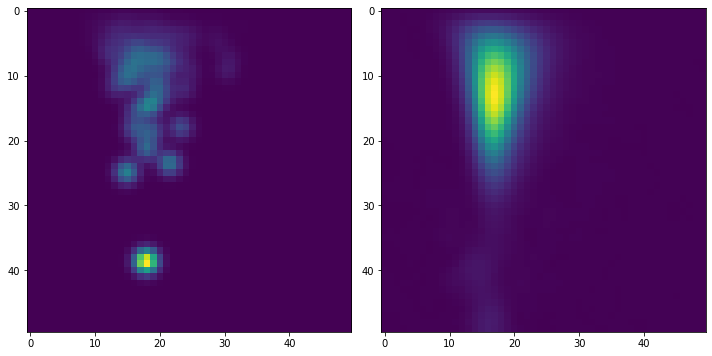

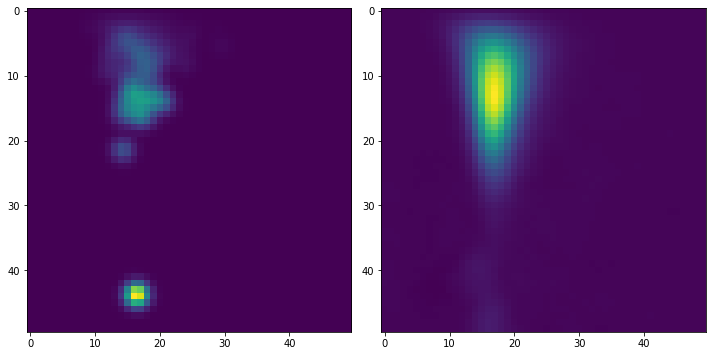

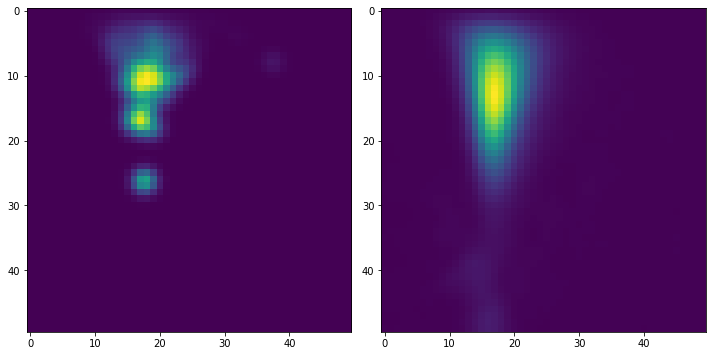

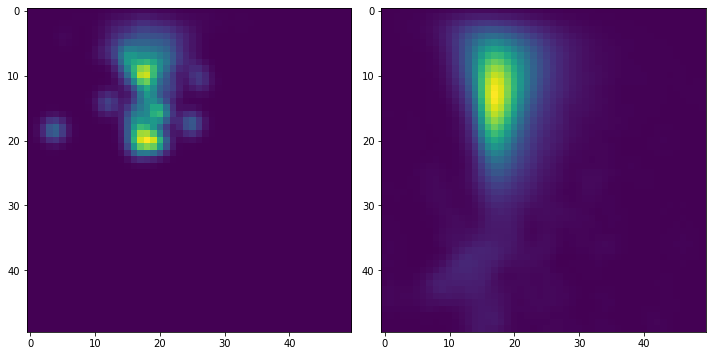

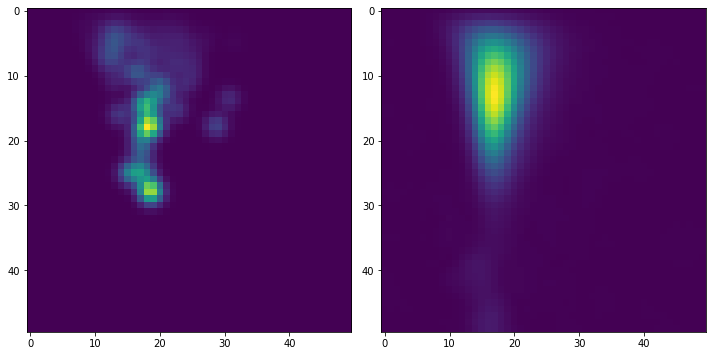

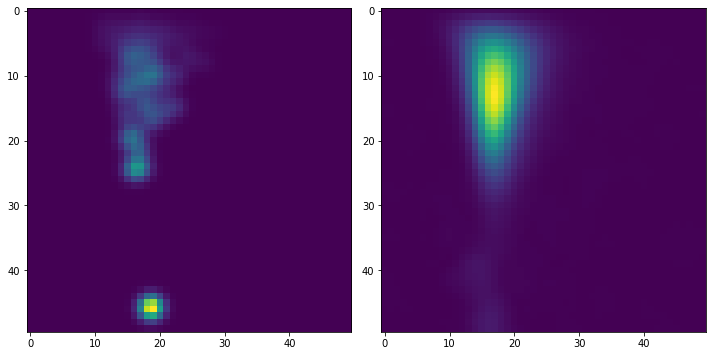

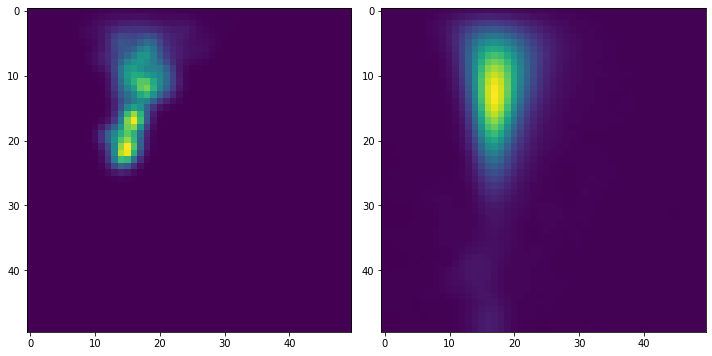

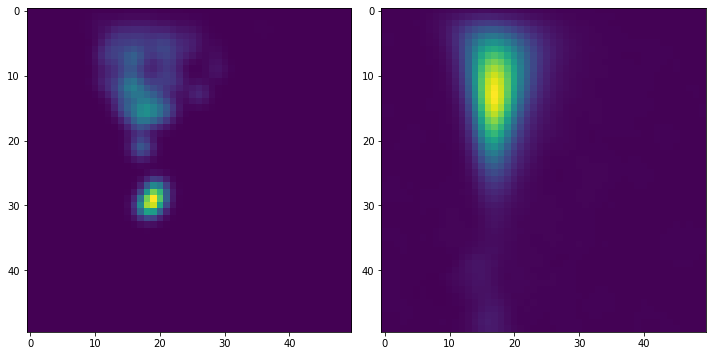

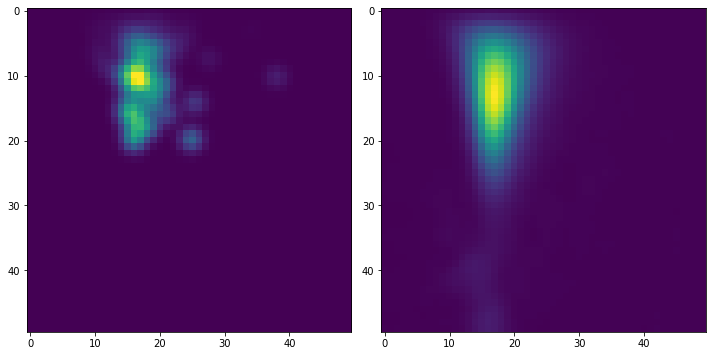

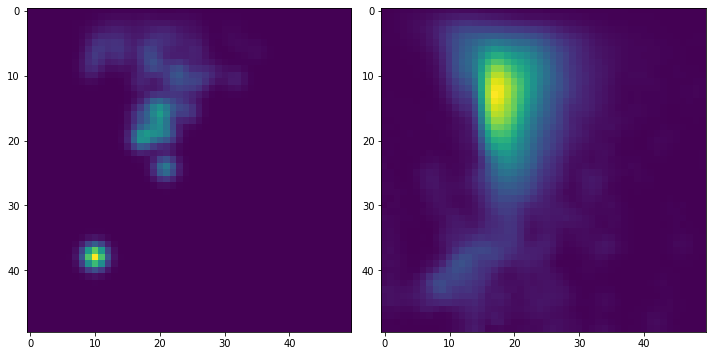

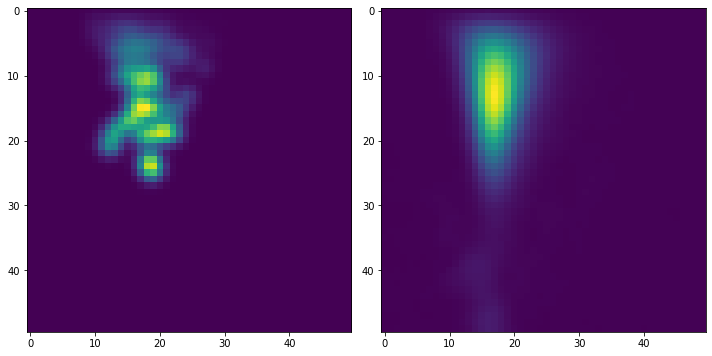

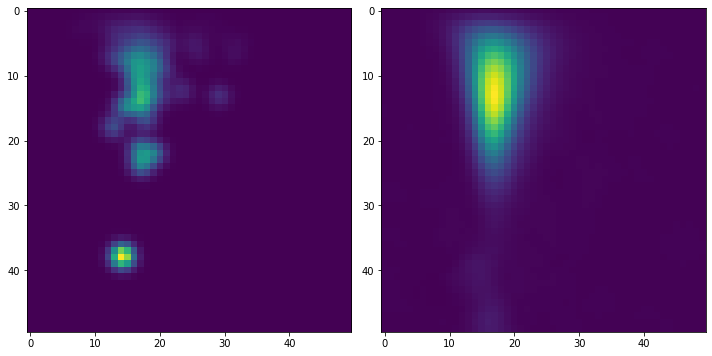

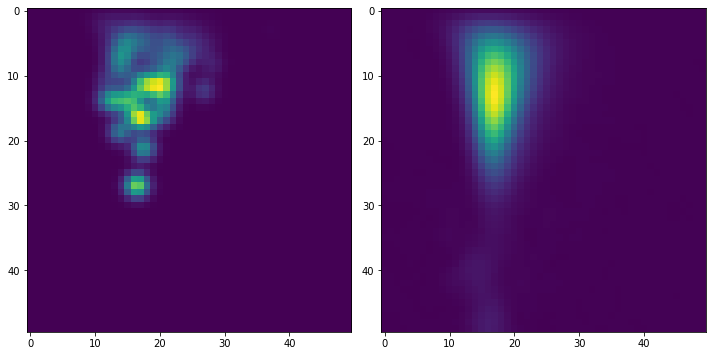

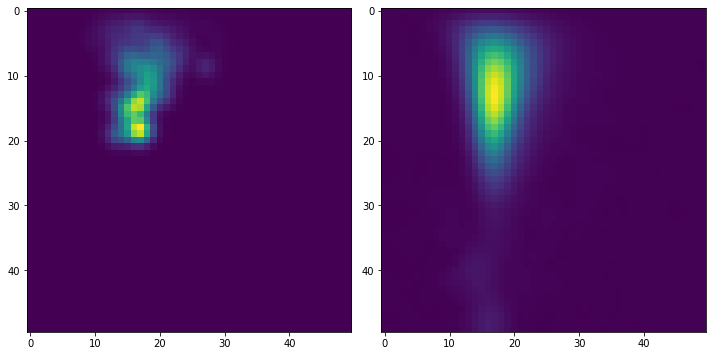

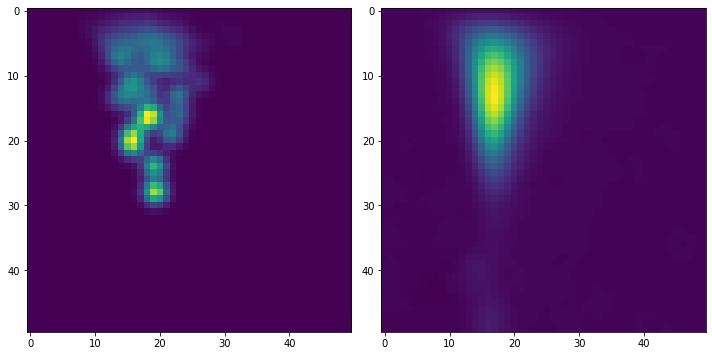

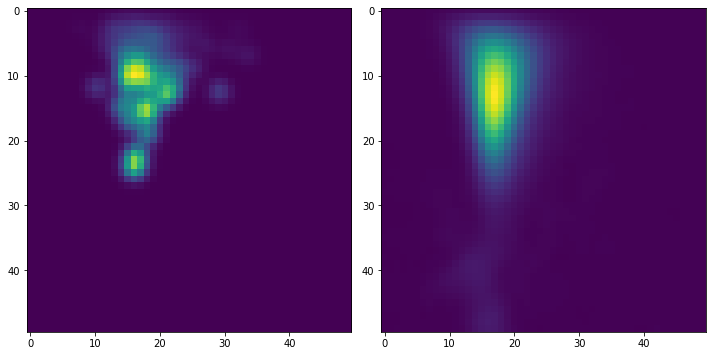

In [6]:
with torch.no_grad():
    for _, _, _, data, PI in dataloader_test:
        PI = PI.reshape(-1, 50, 50).to(device)
        pred = ripsnet(data.to(device)).reshape(-1, 50, 50)
        
        fig, axs = plt.subplots(1, 2, figsize=(10,5))
        axs[0].imshow(PI[0].reshape(50, 50).cpu())
        axs[1].imshow(pred[0].cpu())
        plt.tight_layout()

In [12]:
dgcnn = models.point_clouds_encoders.DGCNN(k=10, dim_in=2, emb_dims=256, 
        dropout=0., output_channels=2500).to(device)

In [13]:
name = 'dgcnn'
dgcnn = train_models.train_pi_model(dgcnn, dataloader_train, dataloader_test, 
                                                  crit=MSELoss(), name=name, lr=1e-3)

0 train loss dgcnn 2.61710786819458 test loss dgcnn 3.3932437896728516
1 train loss dgcnn 1.9470067024230957 test loss dgcnn 1.7105621099472046
2 train loss dgcnn 1.4350248575210571 test loss dgcnn 1.522310733795166
3 train loss dgcnn 1.133237361907959 test loss dgcnn 1.1661899089813232
4 train loss dgcnn 0.9806865453720093 test loss dgcnn 0.9571263790130615
5 train loss dgcnn 0.9147628545761108 test loss dgcnn 0.9669086933135986
6 train loss dgcnn 0.8865686058998108 test loss dgcnn 0.9019176363945007
7 train loss dgcnn 0.8677884936332703 test loss dgcnn 0.9258430600166321
8 train loss dgcnn 0.8588685393333435 test loss dgcnn 0.9085264205932617
9 train loss dgcnn 0.850380539894104 test loss dgcnn 0.8927741646766663
10 train loss dgcnn 0.8441950678825378 test loss dgcnn 0.9126482009887695
11 train loss dgcnn 0.8390756249427795 test loss dgcnn 1.0763276815414429
12 train loss dgcnn 0.8295398950576782 test loss dgcnn 0.9031261801719666
13 train loss dgcnn 0.8261109590530396 test loss dgcn

KeyboardInterrupt: 

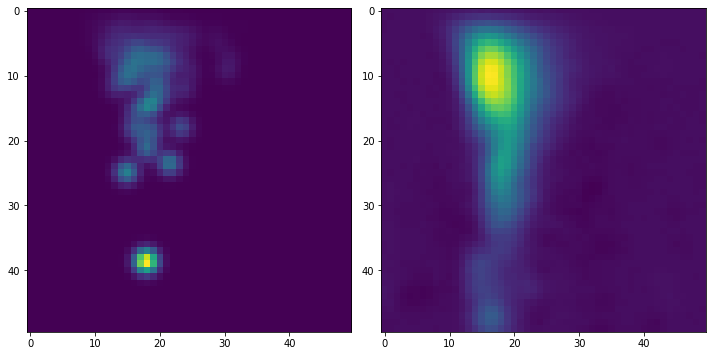

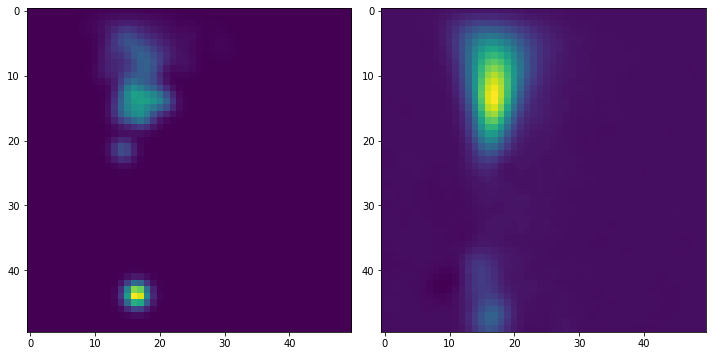

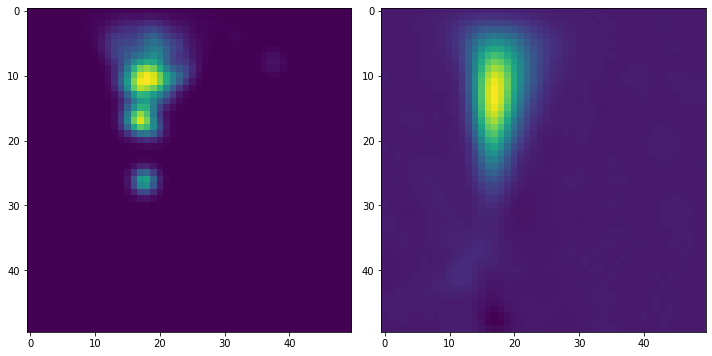

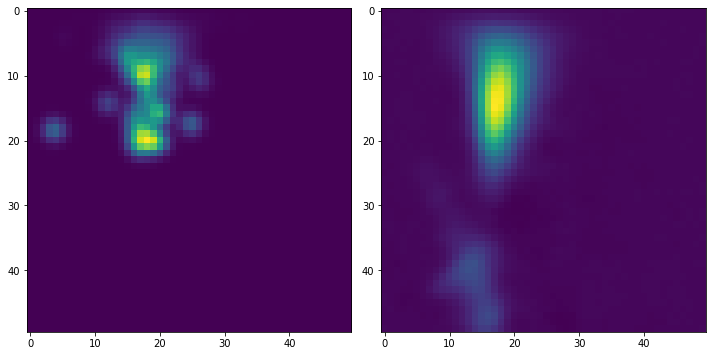

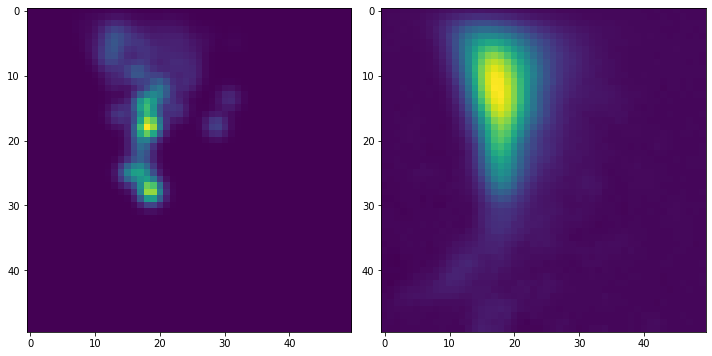

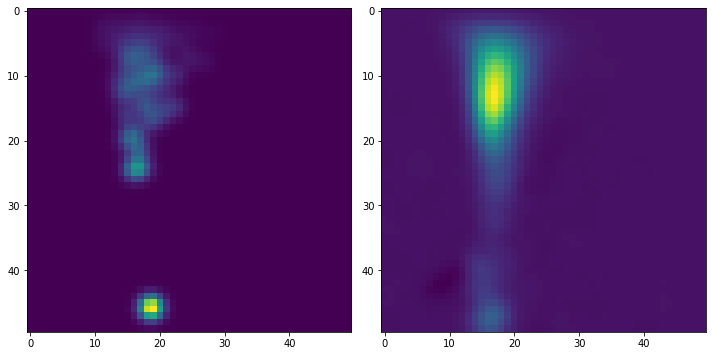

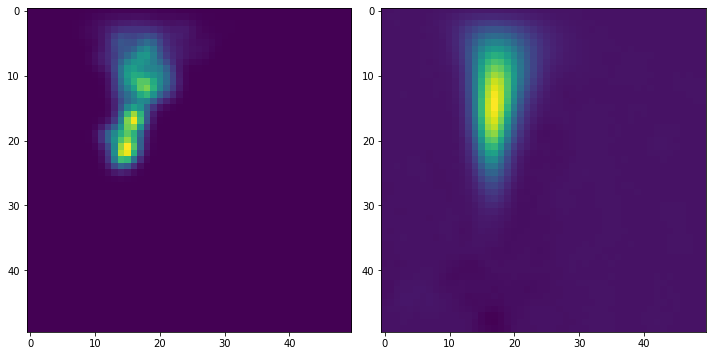

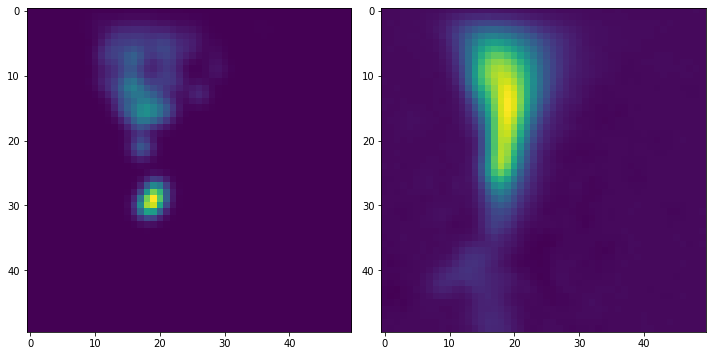

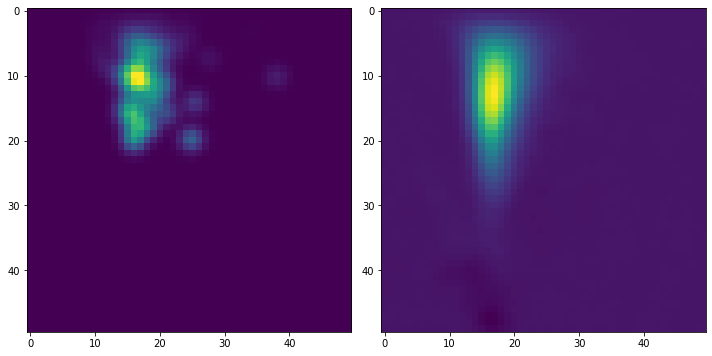

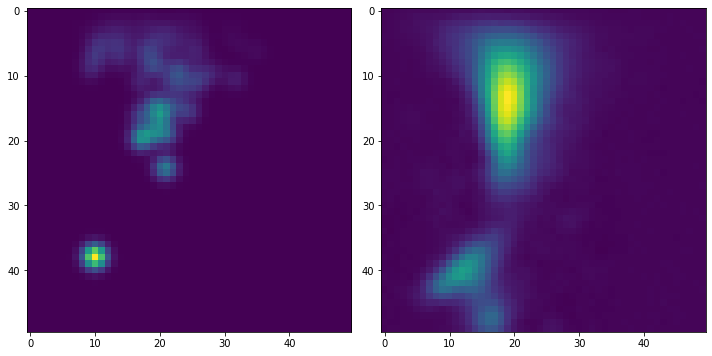

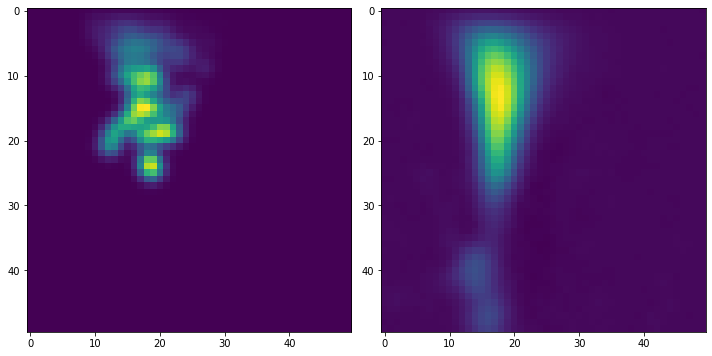

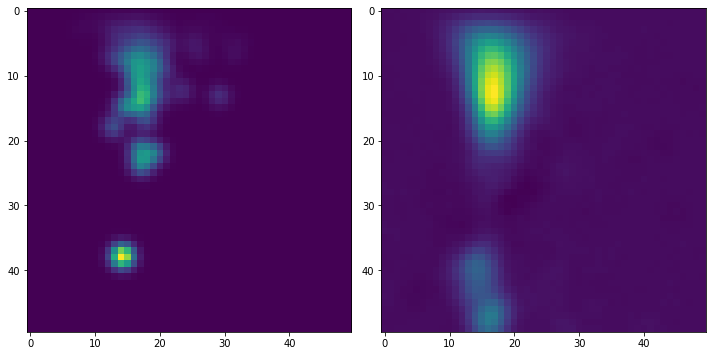

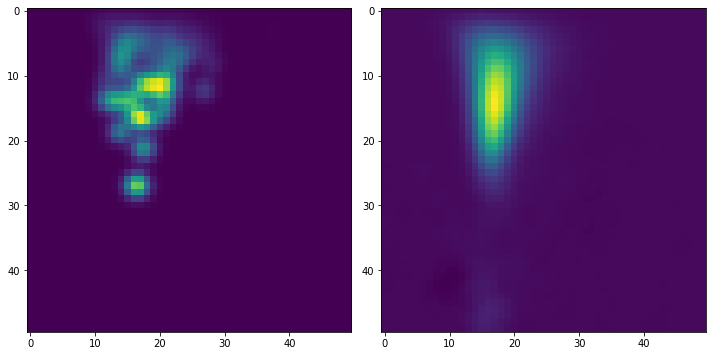

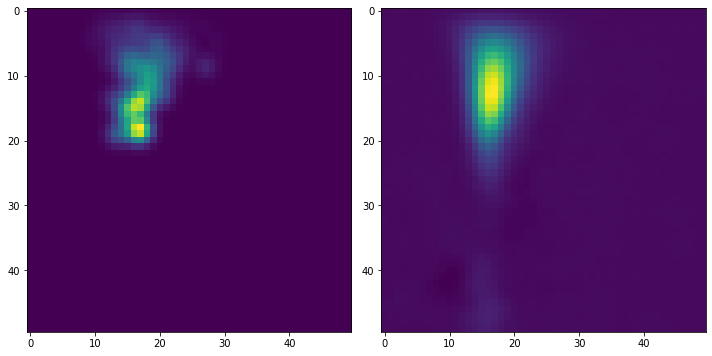

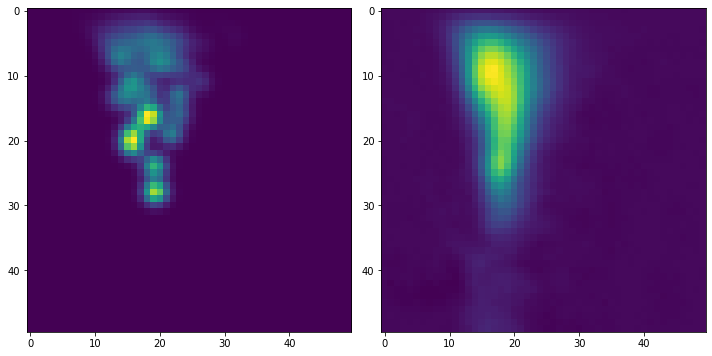

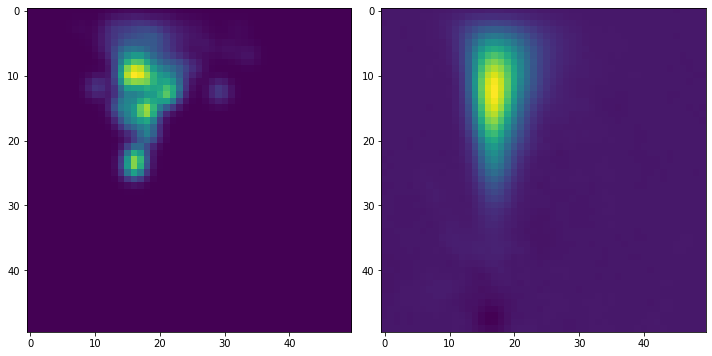

In [14]:
with torch.no_grad():
    for _, _, _, data, PI in dataloader_test:
        PI = PI.reshape(-1, 50, 50).to(device)
        pred = dgcnn(data.to(device)).reshape(-1, 50, 50)
        
        fig, axs = plt.subplots(1, 2, figsize=(10,5))
        axs[0].imshow(PI[0].reshape(50, 50).cpu())
        axs[1].imshow(pred[0].cpu())
        plt.tight_layout()

In [15]:
utils.metrics.logreg_and_rfc_acc(dataloader_train, dataloader_test, name, 'pi_model', dgcnn)

/home/user/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/user/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

0.845 0.817 dgcnn


/home/user/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
